# Optimization for Machine Learning: Computer Lab 1

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [3]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [4]:
M.shape

(722, 892)

In [5]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

Question 3.1 :  Show that if Aw=b, then 
$$
y(t) = \frac{\mathbf{w}_1^\top \tilde{\mathbf{x}}(t) + w_0}{\mathbf{w}_2^\top \tilde{\mathbf{x}}(t) + 1}.
$$

<br>

$$
y(t) = b_t
$$
$$
y(t) = (Aw)_t
$$
$$
y(t) = \tilde{\mathbf{x}}(t)^\top \mathbf{w}_1 + w_0 - y(t) \times \tilde{\mathbf{x}}(t)^\top \mathbf{w}_2 \quad
$$
$$
y(t) \times \ {(} 1+\tilde{\mathbf{x}}(t)^\top \mathbf{w}_2 {)} = \tilde{\mathbf{x}}(t)^\top \mathbf{w}_1 + w_0
$$
$$
y(t) = \frac{\tilde{\mathbf{x}}(t)^\top \mathbf{w}_1 + w_0}{\tilde{\mathbf{x}}(t)^\top \mathbf{w}_2 +1}.
$$

By symmetry of the dot product :
$$
\tilde{\mathbf{x}}(t)^\top \mathbf{w}_1 = \mathbf{w}_1^\top \tilde{\mathbf{x}}(t)
$$
$$
\tilde{\mathbf{x}}(t)^\top \mathbf{w}_2 = \mathbf{w}_2^\top \tilde{\mathbf{x}}(t)
$$

So we get the result.

In [6]:
## Question 3.2: solve with the numpy least squares solver

w_least_squares, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

print(w_least_squares)

[-0.00927821  0.08309371 -0.03672704 ...  0.01980595 -0.03057174
 -0.01188614]


In [7]:
## Question 3.3

predictions = A_test @ w_least_squares
N_test = len(b_test) 
test_error = (1 / N_test) * np.linalg.norm(predictions - b_test)**2

print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793522976


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

In [8]:
lambda_l2 = 1e4

Question 3.4 :

We calculate the gradient of f1:
$$
f_1(w+h) - f_1(w) = \ \frac 12 \|A(w+h)-b\|_2^2 + \frac \lambda 2 \|w+h\|_2^2 - \frac 12 \|Aw-b\|_2^2 - \frac \lambda 2 \|w\|_2^2
$$

$$
f_1(w+h) - f_1(w) = \ < Aw - b, Ah > + < \lambda w, h> + \frac{1}{2} ||Ah||^2 + \frac{\lambda}{2} ||h||^2
$$

$$
f_1(w+h) - f_1(w) = \ < Aw - b, Ah > + < \lambda w, h> + o(h^2)
$$

$$
f_1(w+h) - f_1(w) = \ < A^\top (Aw - b) + \lambda w, h > + o(h^2)
$$

$$
grad(f_1(w)) = A^\top (Aw - b) + \lambda w
$$

<br>

In order to prove f1 is convex, we use the first-order characterization of convexity.

$$
f_1(y) - f_1(x) = \ < A^\top (Ax - b) + \lambda x, y - x > + \ \frac{1}{2} ||A (y-x)||^2 + \frac{\lambda}{2} ||y - x||^2
$$

$$
f_1(y) - f_1(x) = \ < grad(f_1(x)), y - x > + \ \frac{1}{2} ||A (y-x)||^2 + \frac{\lambda}{2} ||y - x||^2
$$

$$
f_1(y) - f_1(x) \quad \geq \quad < grad(f_1(x)), y - x > 
$$

So, f1 is convex.


In [10]:
## Question 3.5
def f(w):
    return (1/2) * np.linalg.norm(A @ w - b)**2 + (lambda_l2/2) * np.linalg.norm(w)**2

def grad_f(w):
    return np.transpose(A) @ (A @ w - b) + lambda_l2 * w

def gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        w = w - gamma * grad_f(w)
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

In [11]:
# L est la plus grande valeur propre de A.T @ A
L = np.linalg.norm(A.T @ A, ord=2)

In [12]:
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 10000

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)

We now compute the evolution of function values and gradient norm. 

Text(0, 0.5, 'Function values')

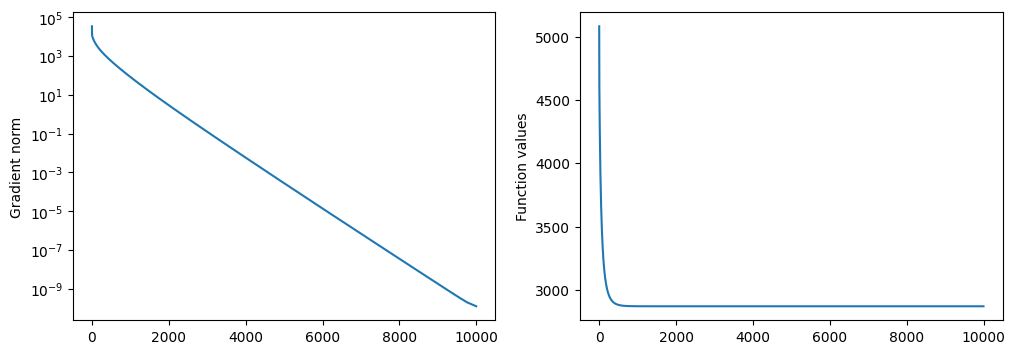

In [13]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

In [14]:
k = 0

for i in range(max_iter) :
    if gradient_norms_GD[i] <= 1 :
        k = i
        break

print(f"Number of iterations needed to get ||grad(f(w))||<= 1 : {k}")
max_iter = k

Number of iterations needed to get ||grad(f(w))||<= 1 : 2332


In [15]:
w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)

In [16]:
# Question 3.6 

predictions = A_test @ w_GD
N_test = len(b_test) 
test_error_l2 = (1 / N_test) * np.linalg.norm(predictions - b_test)**2

print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.52273105427216


What do you observe ?

I observe the mean squared error was divided by roughly 13. Therefore, the solution obtained with regularization is a lot better than the one obtained without regularization.

For a faster algorithm, we could implement accelerated gradient descent.

In [17]:
# Question 3.7 (optional) 

def accelerated_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    y = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        y_prev = y
        y = w - gamma * grad_f(w)
        w = y + (t/(t+3)) * (y - y_prev)

        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms

In [18]:
L = np.linalg.norm(A.T @ A, ord=2)
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 2332

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, w0, step_size, max_iter)

In [19]:
k = 0

for i in range(max_iter) :
    if gradient_norms_AGD[i] <= 1 :
        k = i
        break

print(f"Number of iterations needed to get ||grad(f(w))||<= 1 : {k}")
max_iter = k

Number of iterations needed to get ||grad(f(w))||<= 1 : 1077


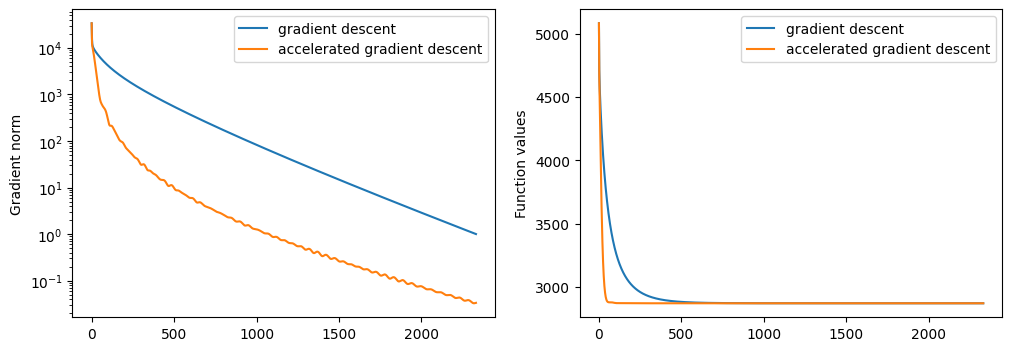

In [20]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

Thanks to the plots, I observe the convergence speed is higher with the accelerated gradient method.
Indeed, the number of iterations needed to get ||grad(f(w))||<= 1 is 1077 instead of 2332, so more than two times less.

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$


Question 4.1 :

$$
F_2 = \frac{1}{2} ||Aw - b||^2 + \lambda ||w||_1
$$

f2 is differentiable and the proximal operator of g2 is easy to compute. So :
$$
f_2 = \frac{1}{2} ||Aw - b||^2
$$

$$
g_2 = \lambda ||w||_1
$$

As we demonstrate in exercise 1 of td3, we know the formula for prox(g2) is given by the soft thresholding operator.
$$
prox_{g2}(x) = \text{sign}(x) \cdot \max(|w| - \lambda, 0)
$$

Then, we calculate the gradient of f2:
$$
f_2(w+h) - f_2(w) = \ < Aw - b, Ah > + \frac{1}{2} ||Ah||^2
$$

$$
f_2(w+h) - f_2(w) = \ < A^\top (Aw - b), h > + o(h^2)
$$

$$
grad(f_2(w)) = A^\top (Aw - b)


In [21]:
lambda_l1 = 1e3

## Question 4.2
def f2(w) :
    return (1/2) * np.linalg.norm(A @ w - b)**2

def grad_f2(w):
    return np.transpose(A) @ (A @ w - b)

def prox_l1(x, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    return np.sign(x) * np.maximum(np.abs(x) - mu, 0)

def proximal_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        grad = grad_f2(w)
        w_temp = w - gamma * grad
        w = prox_l1(w_temp, gamma * lambda_l1)

        f_values.append(f2(w))
        gradient_norms.append(np.linalg.norm(grad_f2(w)))
        
    return w, f_values, gradient_norms

In [22]:
L = np.linalg.norm(A.T @ A, ord=2)
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 10000

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(f2, w0, step_size, max_iter)

print(gradient_norms_PGD)

[44070.41112666459, 32595.872834586567, 27069.676309482682, 24220.97782245901, 22828.68240273503, 21990.143343016312, 21498.791229808274, 21063.175541918532, 20761.217681672806, 20526.578373019147, 20283.015523187474, 20088.37751581225, 19924.223758864, 19780.88128617936, 19672.87348975712, 19563.970974033262, 19440.295928832315, 19326.803580714673, 19216.13870591624, 19115.899363317712, 19041.66006664889, 18967.740748563643, 18905.36554701843, 18837.69617792287, 18777.666108834914, 18697.902244637524, 18593.951890339555, 18508.734968149693, 18436.21933980197, 18372.91275842222, 18319.98025692889, 18285.483341631116, 18251.20705291732, 18219.926182651314, 18178.90693061514, 18138.810970144357, 18106.994947791492, 18086.816485069194, 18064.054937842877, 18039.75971201929, 18022.564300227303, 18004.366649048552, 17971.359465345522, 17940.796051582773, 17918.410428089057, 17891.50462948635, 17867.563652988785, 17846.196668243076, 17818.868610636928, 17800.8626838603, 17783.225906592153, 1

In [23]:
gradient_norms_PGD[5000]

11596.147970528515

In [24]:
k = 0

for i in range(max_iter) :
    if gradient_norms_PGD[i] <= 12000 :
        k = i
        break

print(f"Number of iterations needed to get ||grad(f(w))|| <= 12000 : {k}")
max_iter = k

Number of iterations needed to get ||grad(f(w))|| <= 12000 : 3094


I suggest the following criterion: 
|| grad(f(w)) || <= 12000.

Indeed, the convergence speed is a lot smaller than the one for the least squares method.

In [25]:
# Question 4.3

predictions = A_test @ w_PGD
N_test = len(b_test) 
test_error_l1 = (1 / N_test) * np.linalg.norm(predictions - b_test)**2

print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  2.240341398046963


Compare with the previous test errors. What do you observe?

The test error for l1 penalized solution is the best.
The test error for least squares solution was 780.8984793522976, whereas it was 61.52273105427216 for l2 penalized solution.
So, l1 penalized solution is 30 times better than l2 penalized solution. Even if the l1 regularization is very slow, it gives a better solution in the end.  

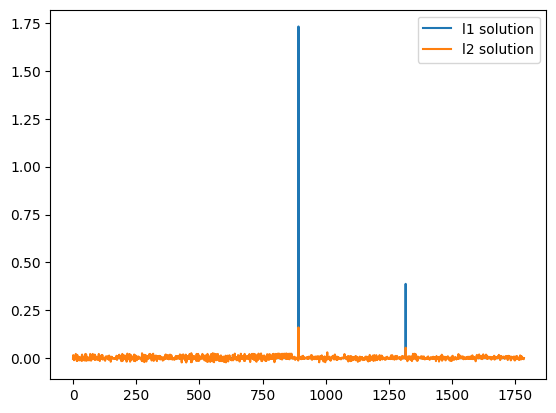

In [26]:
# Let us examine the solution
plt.plot(w_PGD, label = "l1 solution")
plt.plot(w_GD, label = "l2 solution")
plt.legend()

On the plot, we can observe the solutions obtained for l1 regularization and l2 regularization.
For l1 solution, most of the weights are exactly zero except for a two large spikes. This is characteristic of l1 regularization (Lasso), which forces most of nonzero values to be exactly 0.
For l2 solution, there are many small but non zero values. Indeed, l2 regularization (Ridge) penalizes large weights.
The spikes in the l1 solution are significantly larger than in the corresponding values in the l2 solution. This implies l1 regularization focuses on the most influential values, while ignoring the rest.

Question 4.4 :

In order to use the exact line search, we need to calculate
$$
\gamma_k = \arg \min_{\gamma \in \mathbb{R}^+} f(x_k - \gamma \nabla(f(x_k)))
$$
   
<br>

$$
f(x_k - \gamma \nabla(f(x_k))) = \frac{1}{2} \left( \|A x_k - b\|^2 - 2\gamma \langle A x_k - b, A \nabla f(x_k) \rangle + \gamma^2 \|A \nabla f(x_k)\|^2 \right)
$$

$$
\frac{\partial}{\partial \gamma} f(x_k - \gamma \nabla f(x_k)) = - \langle A x_k - b, A \nabla f(x_k) \rangle + \gamma \|A \nabla f(x_k)\|^2
$$

$$
\gamma_k = \frac{<A x_k - b, A \nabla f(x_k) >}{\|A \nabla f(x_k)\|^2}
$$

Since,
$$
\nabla f(x_k) = A^T (A x_k - b)
$$

We can conclude:
$$
\gamma_k = \frac{\|\nabla f(x_k)\|^2}{\|A \nabla f(x_k)\|^2}
$$

In [27]:
# Question 4.4

def proximal_gradient_descent_linesearch(func, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        grad = grad_f2(w)

        def exact_line_search(A, grad_x):
            """Compute step size gamma_k using exact line search"""
            numerator = np.dot(grad_x, grad_x)
            denominator = np.linalg.norm(A @ grad_x)**2
            return numerator / denominator
        gamma_k = exact_line_search(A, grad)

        w_temp = w - gamma_k * grad
        w = prox_l1(w_temp, gamma_k * lambda_l1)

        f_values.append(f2(w))
        gradient_norms.append(np.linalg.norm(grad_f2(w)))
        
    return w, f_values, gradient_norms

In [28]:
w0 = np.zeros(A.shape[1])
step_size = 0
max_iter = 10000

w_PGDL, f_values_PGDL, gradient_norms_PGDL = proximal_gradient_descent_linesearch(f2, w0, step_size, max_iter)

print(gradient_norms_PGDL)

[35577.83761781947, 25277.471392332187, 21026.721166879233, 21202.519308580497, 20349.712331517934, 20071.94750812989, 19715.651249279166, 19522.64440079827, 19245.159444573103, 19027.08059772361, 18886.91729282205, 18725.09273087969, 18475.50142009893, 18321.192722873697, 18236.686711127953, 18158.53938156721, 18069.517753632383, 18028.784935433854, 17969.458419925766, 17889.327068321956, 17831.34631186883, 17775.730989322892, 17699.07328026768, 17623.740343318314, 17588.2572287169, 17541.806960872684, 17510.932373976975, 17433.480704397993, 17380.680783292675, 17324.20039630527, 17272.720008240478, 17197.251512214458, 17151.29503300818, 17101.225614429495, 17063.044423133964, 17010.84705852254, 16966.50953238711, 16925.036980165623, 16894.535506887536, 16867.652198358395, 16839.207217156556, 16785.77253147115, 16747.55684227629, 16721.105901536597, 16689.608588647017, 16647.68974987908, 16616.335263072706, 16597.962573986217, 16581.993833601176, 16566.970821609648, 16542.52001150262,

In [29]:
k = 0

for i in range(max_iter):
    if gradient_norms_PGDL[i] <= 12000 :
        k = i
        break

print(f"Number of iterations needed to get ||grad(f(w))|| <= 12000 : {k}")
max_iter = k

Number of iterations needed to get ||grad(f(w))|| <= 12000 : 1474


We succeeded in making the algorithm faster. The number of iterations needed is now two times lower.
Finally, the algorithm with line search has higher speed than the algorithm with fixed step size.

## Choice of the regularization parameter

In [ ]:
# What is the best value for the regularization parameter rho ?

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

def find_best_rho(X_train, y_train, X_valid, y_valid, rho_values, regularization="l2"):
    best_rho = 0
    best_mse = float('inf')
    best_model = 0

    for rho in rho_values:
        if regularization == "l2":
            model = Ridge(alpha=rho, fit_intercept=False)  
        elif regularization == "l1":
            model = Lasso(alpha=rho, fit_intercept=False) 
        else:
            raise ValueError("Regularization must be 'l2' or 'l1'")

        model.fit(X_train, y_train)

        y_pred_valid = model.predict(X_valid)

        mse = mean_squared_error(y_valid, y_pred_valid)

        if mse < best_mse:
            best_mse = mse
            best_rho = rho
            best_model = model

    return best_rho, best_model, best_mse

X = A
y = b

lim = int(0.8*A.shape[0])
X_train, X_valid = X[:lim], X[lim:]
y_train, y_valid = y[:lim], y[lim:]

rho_values = [10000*0.1**i for i in range(10)]

best_rho_l2, best_model_l2, best_mse_l2 = find_best_rho(X_train, y_train, X_valid, y_valid, rho_values, "l2")
print("Best rho for L2 :", best_rho_l2)
print("MSE value for L2 :", best_mse_l2)

best_rho_l1, best_model_l1, best_mse_l1 = find_best_rho(X_train, y_train, X_valid, y_valid, rho_values, "l1")
print("Best rho for L1 :", best_rho_l1)
print("MSE value for L1 :", best_mse_l1)

Best rho for L2 : 10000.0
MSE value for L2 : 319.0972401990866


C:\Users\nghie\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e+00, tolerance: 1.057e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\nghie\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.020e+00, tolerance: 1.057e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\nghie\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Best rho for L1 : 10.000000000000002
MSE value for L1 : 22.671848615252408


## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [31]:
def f(w,rho):
    return (1/2) * np.linalg.norm(A @ w - b)**2 + (rho/2) * np.linalg.norm(w)**2

def grad_f(w,rho):
    return np.transpose(A) @ (A @ w - b) + rho * w

def accelerated_gradient_descent(func, w0, rho, gamma, max_iter):
    w = w0.copy()
    y = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        y_prev = y
        y = w - gamma * grad_f(w, rho)
        w = y + (t/(t+3)) * (y - y_prev)

        f_values.append(func(w, rho))
        gradient_norms.append(np.linalg.norm(grad_f(w, rho)))
        
    return w, f_values, gradient_norms


def proximal_gradient_descent_linesearch(func, w0, rho, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        grad = grad_f2(w)

        def exact_line_search(A, grad_x):
            """Compute step size gamma_k using exact line search"""
            numerator = np.dot(grad_x, grad_x)
            denominator = np.linalg.norm(A @ grad_x)**2
            return numerator / denominator
        gamma_k = exact_line_search(A, grad)

        w_temp = w - gamma_k * grad
        w = prox_l1(w_temp, gamma_k * rho)

        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f2(w)))
        
    return w, f_values, gradient_norms

In [33]:
rho_values = [10000*0.1**i for i in range(10)]
best_rho_l2 = rho_values[0]
best_rho_l1 = rho_values[0]
max_iter = 3000

predictions = A_test @ w0
N_test = len(b_test) 
mse = (1 / N_test) * np.linalg.norm(predictions - b_test)**2
mse_l1 = mse
mse_l2 = mse

def mse(A_test, b_test, w_least_squares) :
    predictions = A_test @ w_least_squares
    N_test = len(b_test) 
    return (1 / N_test) * np.linalg.norm(predictions - b_test)**2


for rho in rho_values :
    w_AGD, _, _ = accelerated_gradient_descent(f, w0, rho, step_size, max_iter)
    mse_temp = mse(A_test, b_test, w_AGD)
    if mse_temp < mse_l2 :
        mse_l2 = mse_temp
        best_rho_l2 = rho

    w_PGDL, _, _ = proximal_gradient_descent_linesearch(f2, w0, rho, max_iter)
    mse_temp = mse(A_test, b_test, w_PGDL)
    if mse_temp < mse_l1 :
        mse_l1 = mse_temp
        best_rho_l1 = rho


print(f'For l2 regularization, the best regularization parameter is {best_rho_l2} and the mean squared error is {mse_l2}')
print(f'For l1 regularization, the best regularization parameter is {best_rho_l1} and the mean squared error is {mse_l1}')

For l2 regularization, the best regularization parameter is 10000.0 and the mean squared error is 79.82867294741004
For l1 regularization, the best regularization parameter is 100.00000000000001 and the mean squared error is 0.6257799156176977
